In [1]:
%load_ext autoreload
%autoreload 2 
import sim
import strategy as strat
import message
import pickle
from datetime import datetime
from matplotlib import pyplot as plt
from pylab import rcParams
from sortedcontainers import SortedDict
from collections import deque
import copy
rcParams['figure.figsize'] = 15, 10

In [2]:
def show(pnl, times):
    times = list(map(datetime.fromtimestamp, times))
    plt.plot(times, pnl)
    plt.grid(True)
    plt.show()

In [3]:
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)
len(data)

745530

In [4]:
def average_asks(data):
    n = 1000
    asks = [0] * n
    for update in data:
        mid_price = (update.order_book.bid_price[0] + update.order_book.ask_price[0]) / 2
        for i in range(len(update.order_book.ask_price)):
            j = 0
            while (update.order_book.ask_price[i] > mid_price + j):
                j += 1
            asks[j] += update.order_book.ask_quantity[i]
    last = 0
    for i in range(n):
        asks[i] /= len(data)
        if (asks[i] >= 0.01):
            last = i
    return asks[:(last + 1)]
average_asks(data)

[0.0,
 0.10504166544336051,
 0.08570807377033493,
 0.09348441432134434,
 0.1402553049534825,
 0.21027329516987023,
 0.32502661665530064,
 0.42904679652009,
 0.6373330764711698,
 0.7365604813955605,
 0.7255910971694804,
 0.781133379830441,
 0.9068963993269709,
 0.8809717238920278,
 0.9484823833147545,
 0.5943164480234259,
 0.4205752494895945,
 0.2877114115179101,
 0.21414794962905717,
 0.15343280116689503,
 0.10495645716199761,
 0.06421876464126179,
 0.052830824214987755,
 0.047462052997196476,
 0.03566911185197052,
 0.02813690054726162,
 0.02345275069547902,
 0.02162853616353586,
 0.017630327965340614,
 0.0137161292556977,
 0.012104408317572972,
 0.010416300900031018]

In [5]:
def average_bids(data):
    n = 1000
    bids = [0] * n
    for update in data:
        mid_price = (update.order_book.bid_price[0] + update.order_book.ask_price[0]) / 2
        for i in range(len(update.order_book.bid_price)):
            j = 0
            while (update.order_book.bid_price[i] < mid_price + j):
                j -= 1
            bids[-j] += update.order_book.bid_quantity[i]
    last = 0
    for i in range(n):
        bids[i] /= len(data)
        if (bids[i] >= 0.01):
            last = i
    return bids[:(last + 1)]

average_bids(data)

[0.0,
 0.14516979505317423,
 0.12639901694901434,
 0.16059822530947848,
 0.19310342654080903,
 0.2756683083202419,
 0.3647778599478748,
 0.41562101632199966,
 0.5586220154352064,
 0.6203625509911319,
 0.6511203989397056,
 0.7203772322759138,
 0.8142150572842413,
 0.8636223717577158,
 1.0417136789428703,
 0.6956193262389052,
 0.5238042438304603,
 0.4123456843520577,
 0.3417683053143053,
 0.2899694483520576,
 0.2046864982334232,
 0.115051161153785,
 0.07933516984426449,
 0.06499226728367136,
 0.04272924322830559,
 0.0384633454200358,
 0.02941665825520132,
 0.0251327063391153,
 0.020540976462383474,
 0.015504846611136191,
 0.01098596043619974,
 0.01130682544096142]

In [6]:
EPS = 1e-12

In [10]:
class Task4(strat.Strategy):
    
    def __init__(self, tax):
        self.usd = []
        self.btc = []
        self.tax = tax    
        self.asks = [0.0,
         0.10504166544336051,
         0.08570807377033493,
         0.09348441432134434,
         0.1402553049534825,
         0.21027329516987023,
         0.32502661665530064,
         0.42904679652009,
         0.6373330764711698,
         0.7365604813955605,
         0.7255910971694804,
         0.781133379830441,
         0.9068963993269709,
         0.8809717238920278,
         0.9484823833147545,
         0.5943164480234259,
         0.4205752494895945,
         0.2877114115179101,
         0.21414794962905717,
         0.15343280116689503,
         0.10495645716199761,
         0.06421876464126179,
         0.052830824214987755,
         0.047462052997196476,
         0.03566911185197052,
         0.02813690054726162,
         0.02345275069547902,
         0.02162853616353586,
         0.017630327965340614,
         0.0137161292556977,
         0.012104408317572972,
         0.010416300900031018]
        self.bids = [0.0,
         0.14516979505317423,
         0.12639901694901434,
         0.16059822530947848,
         0.19310342654080903,
         0.2756683083202419,
         0.3647778599478748,
         0.41562101632199966,
         0.5586220154352064,
         0.6203625509911319,
         0.6511203989397056,
         0.7203772322759138,
         0.8142150572842413,
         0.8636223717577158,
         1.0417136789428703,
         0.6956193262389052,
         0.5238042438304603,
         0.4123456843520577,
         0.3417683053143053,
         0.2899694483520576,
         0.2046864982334232,
         0.115051161153785,
         0.07933516984426449,
         0.06499226728367136,
         0.04272924322830559,
         0.0384633454200358,
         0.02941665825520132,
         0.0251327063391153,
         0.020540976462383474,
         0.015504846611136191,
         0.01098596043619974,
         0.01130682544096142]

    def on_update(self, update: message.Update, balance: message.Balance) -> float:
        self.usd.append(balance.usd)
        self.btc.append(balance.btc)
        
        mid_price = (update.order_book.bid_price[0] + update.order_book.ask_price[0]) / 2
        
        if mid_price < update.future_mid_price:
            bids = copy.copy(self.bids)
            money = 0
            i = 0
            j = 0
            while (j < len(bids) and i < len(update.order_book.ask_price) and update.order_book.ask_price[i] * self.tax < update.future_mid_price - j) :
                
                quantity = min(update.order_book.ask_quantity[i], bids[j])
                money += update.order_book.ask_price[i] * quantity
                bids[j] -= quantity
                update.order_book.ask_quantity[i] -= quantity

                if update.order_book.ask_quantity[i] <= 0 + EPS:
                    i += 1
                if bids[j] <= 0 + EPS:
                    j += 1

            return money
        else:
            asks = copy.copy(self.asks)
            btc = 0
            i = 0
            j = 0
            while (j < len(asks) and i < len(update.order_book.bid_price) and update.order_book.bid_price[i] > (update.future_mid_price + j) * self.tax) :
                
                quantity = min(update.order_book.bid_quantity[i], asks[j])
                btc += quantity
                asks[j] -= quantity
                update.order_book.bid_quantity[i] -= quantity

                if update.order_book.bid_quantity[i] <= 0 + EPS:
                    i += 1
                if asks[j] <= 0 + EPS:
                    j += 1
                
            return -btc
        return 0

In [11]:
start_balance = 100000

  0%|          | 0/745530 [00:00<?, ?it/s]

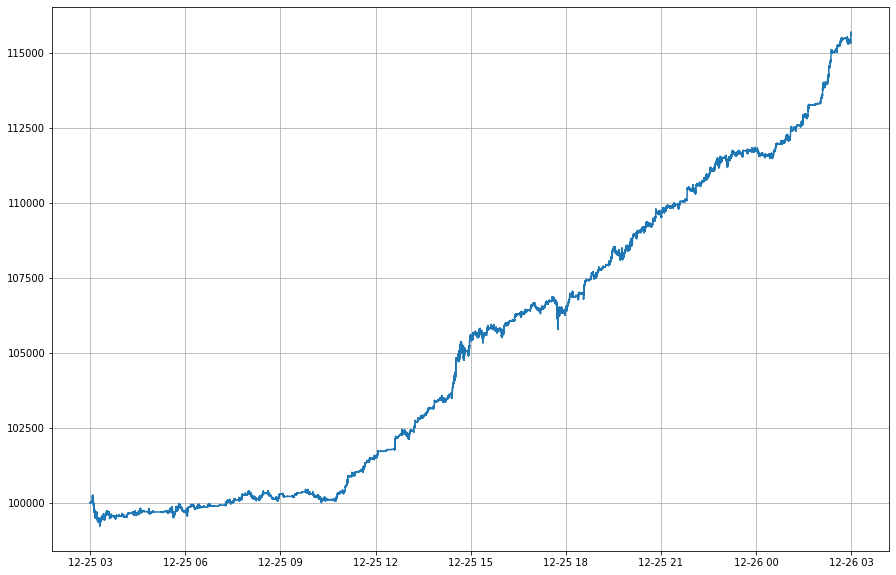

In [12]:
solution_easy = Task4(1.00005)
balance_history, pnl, times, mid_price = sim.simulate(
    strategy=solution_easy,
    data=data,
    start_balance=start_balance,
    version='task4easy',
)
show(pnl, times)

  0%|          | 0/745530 [00:00<?, ?it/s]

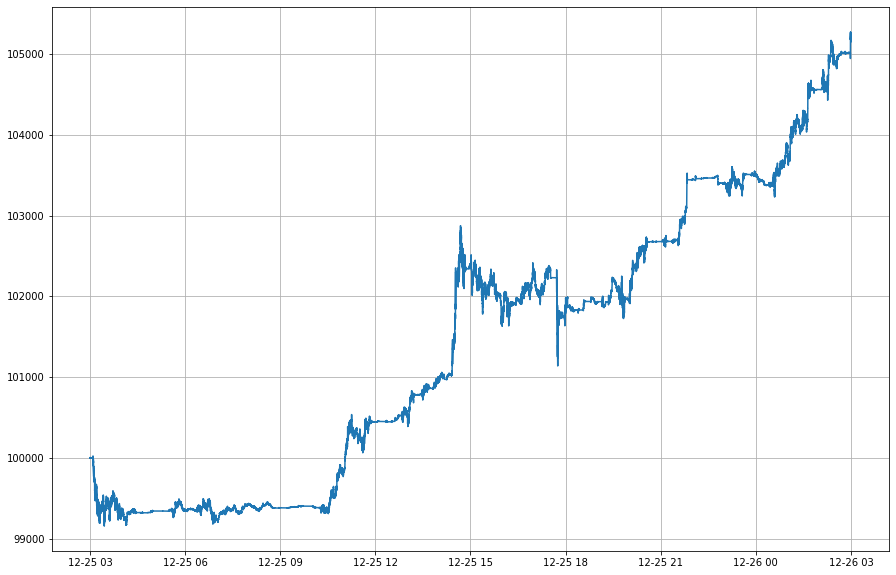

In [13]:
solution_hard = Task4(1.00025)
balance_history, pnl, times, mid_price = sim.simulate(
    strategy=solution_hard,
    data=data,
    start_balance=start_balance,
    version='task4hard',
)
show(pnl, times)